* Image size: (224, 224, 3)

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [4]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# VGG16

## Stage 1 - Initial training

In [6]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=128, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


In [7]:
# Load pre-trained VGG16
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dropout(rate=0.25, name='dropout'))
vgg16.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg16_base.trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-1-layer-stage-1-ckpt.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=50, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

vgg16.save('./models/vgg16-1-layer-stage-1-model.h5')
_ = gc.collect()

Learning rate:  0.001
Epoch 1/50
Learning rate:  0.001
 - 211s - loss: 2.7839 - acc: 0.3816 - val_loss: 2.3169 - val_acc: 0.4803
Epoch 2/50
Learning rate:  0.001
 - 187s - loss: 1.9948 - acc: 0.5324 - val_loss: 2.2723 - val_acc: 0.5157
Epoch 3/50
Learning rate:  0.001
 - 185s - loss: 1.8425 - acc: 0.5705 - val_loss: 1.9428 - val_acc: 0.5510
Epoch 4/50
Learning rate:  0.001
 - 186s - loss: 1.7880 - acc: 0.5806 - val_loss: 1.9053 - val_acc: 0.5658
Epoch 5/50
Learning rate:  0.001
 - 189s - loss: 1.7770 - acc: 0.5909 - val_loss: 2.0233 - val_acc: 0.5644
Epoch 6/50
Learning rate:  0.001
 - 186s - loss: 1.7142 - acc: 0.6105 - val_loss: 1.8493 - val_acc: 0.6025
Epoch 7/50
Learning rate:  0.001
 - 186s - loss: 1.6744 - acc: 0.6202 - val_loss: 1.8908 - val_acc: 0.5965
Epoch 8/50
Learning rate:  0.001
 - 184s - loss: 1.6822 - acc: 0.6264 - val_loss: 1.8932 - val_acc: 0.5888
Epoch 9/50
Learning rate:  0.001
 - 188s - loss: 1.6731 - acc: 0.6259 - val_loss: 1.7846 - val_acc: 0.6238
Epoch 10/50
Lea

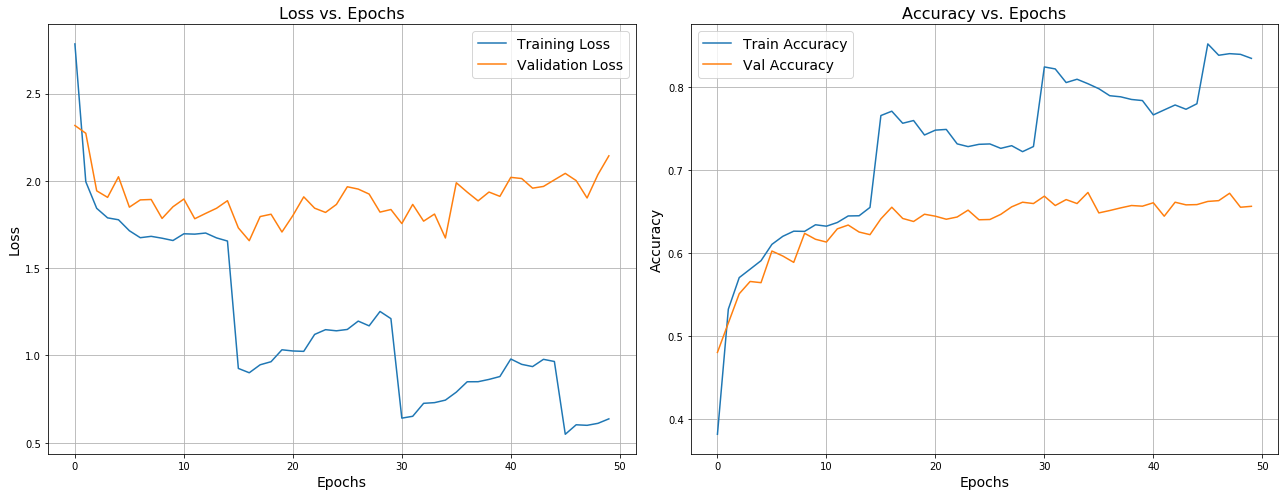

In [9]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

## Stage 2 - Data Augmentation

In [6]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
# training set
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_gen.flow_from_directory(
    train_dir, 
    batch_size=128, 
    classes=classes, 
    target_size=(224, 224))

# validation set
val_gen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_gen.flow_from_directory(
    val_dir, 
    batch_size=286, 
    classes=classes, 
    target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


In [11]:
# Load trained model
vgg16 = load_model('./models/vgg16-1-layer-stage-1-model.h5')
vgg16.layers[0].trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-1-layer-stage-2-ckpt.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=50, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

vgg16.save('./models/vgg16-1-layer-stage-2-model.h5')
_ = gc.collect()

Learning rate:  0.001
Epoch 1/50
Learning rate:  0.001
 - 344s - loss: 2.4316 - acc: 0.5661 - val_loss: 2.1261 - val_acc: 0.6618
Epoch 2/50
Learning rate:  0.001
 - 305s - loss: 2.2324 - acc: 0.5827 - val_loss: 2.0825 - val_acc: 0.6716
Epoch 3/50
Learning rate:  0.001
 - 303s - loss: 2.2156 - acc: 0.5943 - val_loss: 2.1376 - val_acc: 0.6623
Epoch 4/50
Learning rate:  0.001
 - 302s - loss: 2.2400 - acc: 0.5884 - val_loss: 2.1075 - val_acc: 0.6648
Epoch 5/50
Learning rate:  0.001
 - 302s - loss: 2.2906 - acc: 0.5889 - val_loss: 2.0635 - val_acc: 0.6659
Epoch 6/50
Learning rate:  0.001
 - 299s - loss: 2.2270 - acc: 0.6039 - val_loss: 2.1770 - val_acc: 0.6648
Epoch 7/50
Learning rate:  0.001
 - 303s - loss: 2.2604 - acc: 0.5941 - val_loss: 2.0808 - val_acc: 0.6691
Epoch 8/50
Learning rate:  0.001
 - 308s - loss: 2.2150 - acc: 0.6063 - val_loss: 2.1134 - val_acc: 0.6659
Epoch 9/50
Learning rate:  0.001
 - 303s - loss: 2.2568 - acc: 0.5995 - val_loss: 2.3205 - val_acc: 0.6554
Epoch 10/50
Lea

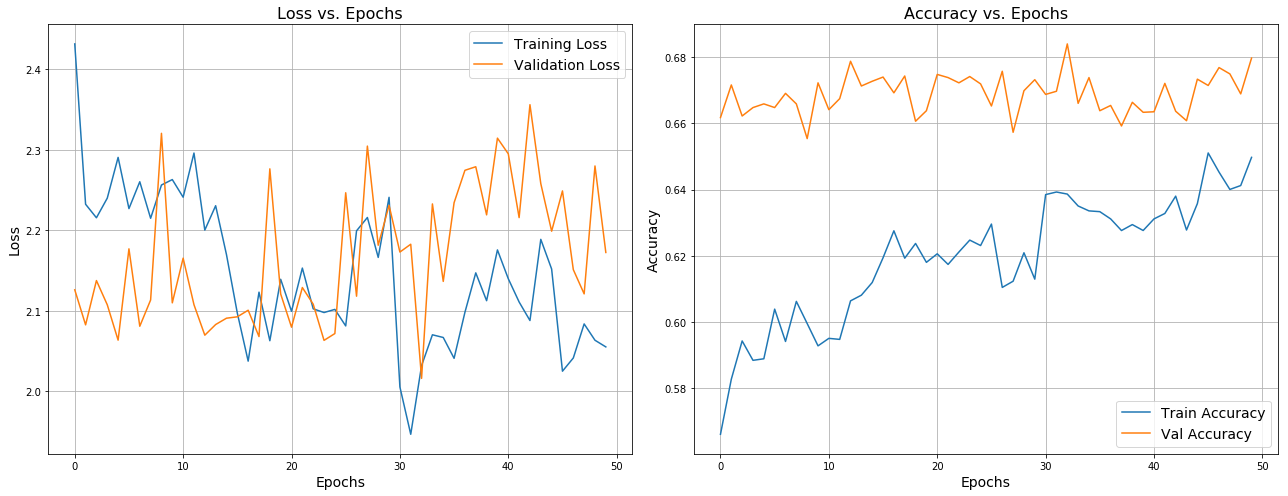

In [13]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Make Predictions

In [9]:
# # Load test images
# test_ids = []
# test_images = []
# for idx in test_df['id'].values:
#     if os.path.exists('./data/test/' + str(idx) + '.jpg'):
#         img = Image.open('./data/test/' + str(idx) + '.jpg')
#         if img.mode != 'RGB':
#             img = img.convert('RGB')
#         img = img.resize((224, 224))
#         img = np.asarray(img, dtype=K.floatx())
#         test_images.append(img)
#         test_ids.append(idx)

# # Re-scale the images
# test_images = np.array(test_images, dtype=K.floatx())
# test_images = test_images / 255.0

In [10]:
# # Load the saved model
# vgg16 = load_model('./models/vgg16-1-layer-dropout-initial.h5')

# # Make predictions
# test_pred = vgg16.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

In [11]:
# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission.loc[df_submission['predicted'].isnull(), 'predicted'] = guess
# df_submission['predicted'] = df_submission['predicted'].astype(int)

# # Save to disk
# df_submission.to_csv('./result/vgg16-1-layer-dropout-initial.csv', columns=['id', 'predicted'], index=False)

# _ = gc.collect()